In [1]:
import string
import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_datareader import data as wb

In [2]:
# collecting stock data from Alpha Vantage platform for AAPL, MSFT, GOOGL, IBM, and AMZN from start_date (2015)

# we use Alpha Vantage over Quantl since data is no longer supported by their community since 2018-03. 
# in order to use Alpha Vantage data, you will need to request your own API key, and replace the field below.
# keys can be acquired for free here: https://www.alphavantage.co/support/#api-key

# alternatively, you can simply pull from other resources like Yahoo Finance with the Pandas' Datareader.

key = '################' # placeholder for private API key. Replace key's value with your own
start_date = '2015-01-01' # start date for our timeseries data

### Comment out following block of code when using your own key ###
with open('Alpha_Vantage_API_Key.txt','r') as f:
    key = f.read()
f.close()
### End block ###

# pulls raw data and saves as a CSV
def stock_timeseries_dataframe(symbol, key):
    directory = "Sharpe_Portfolio_Allocation/" + symbol + "_Data"
    stock_ts = TimeSeries(key=key, output_format='pandas')
    data, metadata = stock_ts.get_daily_adjusted(symbol=symbol,outputsize='full')
    data.to_csv(directory)
    return pd.read_csv(directory, index_col='date', parse_dates=True)

# cleans time series data frames from Alpha Vantage
def clean_stock_dataframes(stock):
    stock.columns = stock.columns.str.lstrip(string.digits).str.replace(".",'', regex=True).str.strip().str.title() # fixing cols
    stock = stock[::-1] # reversing order so last entry is present date
    stock = stock.loc[start_date:] # starts record at start date until present. Comment if want data for all time
    return stock

# creating stock time series data frames from Alpha Vantage data
aapl = stock_timeseries_dataframe('AAPL', key)
msft = stock_timeseries_dataframe('MSFT', key)
googl = stock_timeseries_dataframe('GOOGL', key)
ibm = stock_timeseries_dataframe('IBM', key)
amzn = stock_timeseries_dataframe('AMZN', key)

# cleaning data frames to match our desired format
aapl = clean_stock_dataframes(aapl)
msft = clean_stock_dataframes(msft)
googl = clean_stock_dataframes(googl)
ibm = clean_stock_dataframes(ibm)
amzn = clean_stock_dataframes(amzn)

# saving all companies/data in list for later use
companies = [aapl, msft, googl, ibm, amzn]

In [3]:
# quick check of imported stocks
aapl.head()

,Open,High,Low,Close,Adjusted Close,Volume,Dividend Amount,Split Coefficient
date,,,,,,,,
2015-01-02,111.39,111.44,107.350,109.33,24.779987,53204626.0,0.0,1.0
2015-01-05,108.29,108.65,105.410,106.25,24.081896,64285491.0,0.0,1.0
2015-01-06,106.54,107.43,104.630,106.26,24.084162,65797116.0,0.0,1.0
2015-01-07,107.20,108.20,106.695,107.75,24.421875,40105934.0,0.0,1.0
2015-01-08,109.23,112.15,108.700,111.89,25.360219,59364547.0,0.0,1.0


Text(0.5, 1.0, 'Total Example Portfolio Value 2015-Present')

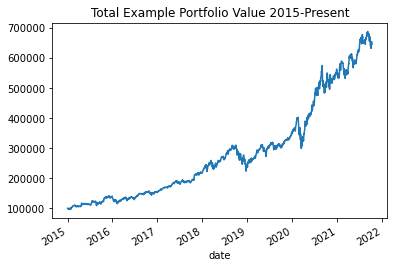

In [51]:
### generating a sample portfolio of this collection of stocks
for df_stock in (aapl, msft, googl, ibm, amzn):
    df_stock['Normalized Return'] = df_stock['Adjusted Close']/df_stock.iloc[0]['Adjusted Close']
    
# appending 'allocation' column that assumes we have 25% in AAPL, 25% in MSFT, 20% in GOOGL, 10% in IBM, 20% in AMZN
for stock,allocation in zip([aapl,msft,googl,ibm,amzn],[.25,.25,.2,.1,.2]):
    stock['Allocation'] = stock['Normalized Return']*allocation
    
# then assume allocated $100K into this portfolio
for stock in [aapl,msft,googl,ibm,amzn]:
    stock['Position Values'] = stock['Allocation']*100000
    
# combine these positions into a single dataframe aggregating all our positions, and calculate total value
portfolio_val = pd.concat([aapl['Position Values'], msft['Position Values'], googl['Position Values'], 
                           ibm['Position Values'], amzn['Position Values']], axis = 1)
portfolio_val.columns = ['AAPL Pos','MSFT Pos', 'GOOGL Pos', 'IBM Pos', 'AMZN Pos']
portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)

# plot this value over time
portfolio_val['Total Pos'].plot()
plt.title("Total Example Portfolio Value 2015-Present")

Text(0.5, 1.0, 'Position Values 2015-Present')

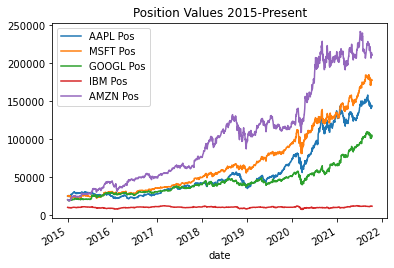

In [50]:
portfolio_val.drop('Total Pos', axis=1).plot(kind='line')
plt.title("Position Values 2015-Present")

In [44]:
### Markowitz portfolio optimization

# now use Monte Carlo Simulation to generate weights of portfolio and efficiency frontier
df = pd.concat([aapl['Adjusted Close'], msft['Adjusted Close'], googl['Adjusted Close'],
               ibm['Adjusted Close'], amzn['Adjusted Close']], axis = 1)
df = df.set_axis(['AAPL', 'MSFT', 'GOOGL', 'IBM', 'AMZN'], axis=1, inplace=False)
df.head()

,AAPL,MSFT,GOOGL,IBM,AMZN
date,,,,,
2015-01-02,24.779987,41.271258,529.55,121.782196,308.52
2015-01-05,24.081896,40.887319,519.46,119.865964,302.19
2015-01-06,24.084162,40.291551,506.64,117.280929,295.29
2015-01-07,24.421875,40.803470,505.15,116.514436,298.42
2015-01-08,25.360219,42.003832,506.91,119.046869,300.46


<AxesSubplot:xlabel='date'>

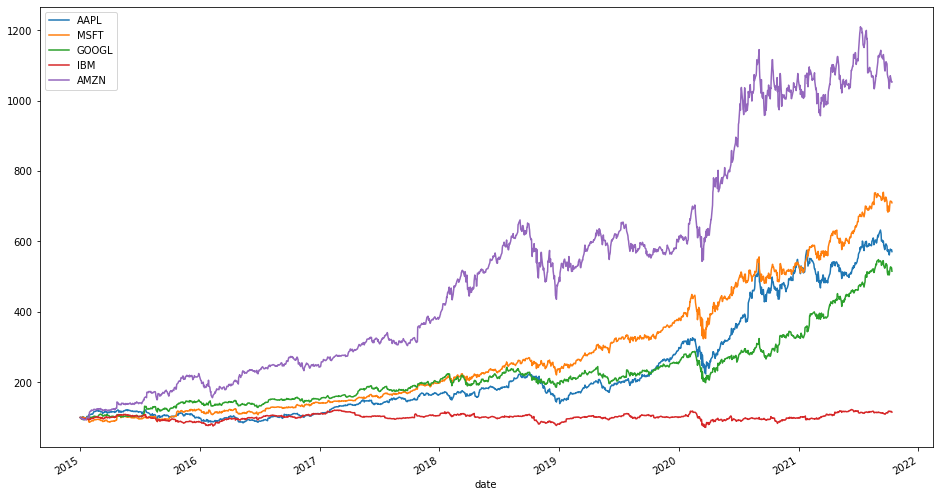

In [5]:
# plotting normalized return values to number 100
(df/df.iloc[0]*100).plot(figsize=(16,9))

In [46]:
# calculating logarithmic returns of companies
log_returns = np.log(df/df.shift(1))
# calculate mean, covariance, and correlation matrices of each company
mean = log_returns.mean() * 250 # ~250 trading days in year
cov = log_returns.cov() * 250
corr = log_returns.corr()
print('Portfolio Stock Correlations: ')
corr

Portfolio Stock Correlations: 


,AAPL,MSFT,GOOGL,IBM,AMZN
AAPL,1.000000,0.688699,0.610001,0.440479,0.562284
MSFT,0.688699,1.000000,0.730837,0.514232,0.652254
GOOGL,0.610001,0.730837,1.000000,0.469093,0.647316
IBM,0.440479,0.514232,0.469093,1.000000,0.330467
AMZN,0.562284,0.652254,0.647316,0.330467,1.000000


In [7]:
# determining number of assets from our portfolio in generalized manner (in this example, 5)
num_assets = len(companies)
# Monte Carlo simulation of 10,000 different weight value combinations for our assets
portfolio_returns=[] # empty list to store returns
portfolio_volatilities=[] # empty list to store volatilities
portfolio_weights=[]
for x in range(10000):
    # creating randomized weights for our assets in our portfolio
    weights = np.random.random(num_assets)
    weights /= np.sum(weights) # ensures weights cannot exceed total of 100%
    portfolio_weights.append(weights)
    # expected portfolio return
    portfolio_returns.append(np.sum(weights * mean)) # sum of weighted average log returns
    # expected portfolio volatility (and by extension variance)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(cov, weights)))) # square root of expected portfolio variance

In [40]:
# converting lists into arrays
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)
portfolio_returns,portfolio_volatilities

# combining these Return and Volatility arrays into a dataframe
portfolios = pd.DataFrame({'Return':portfolio_returns,'Volatility':portfolio_volatilities})

# converting weights 2D array into dataframe
portfolio_weights = pd.DataFrame(portfolio_weights)
portfolio_weights.columns = ['% AAPL','% MSFT','% GOOGL','% IBM', '% AMZN']

# combining these two dataframes for a single simulation of portfolios, weights appended
portfolios = pd.concat([portfolios, portfolio_weights], axis=1)
portfolios.head()

,Return,Volatility,% AAPL,% MSFT,% GOOGL,% IBM,% AMZN
0,0.239777,0.224891,0.174112,0.239100,0.239950,0.156256,0.190582
1,0.185483,0.216013,0.011615,0.217706,0.046412,0.435088,0.289179
2,0.278247,0.239275,0.058579,0.257907,0.338059,0.034434,0.311021
3,0.284992,0.250561,0.478862,0.054414,0.044070,0.028623,0.394030
4,0.198765,0.215374,0.056741,0.224148,0.182182,0.336614,0.200315


Text(0, 0.5, 'Expected Return')

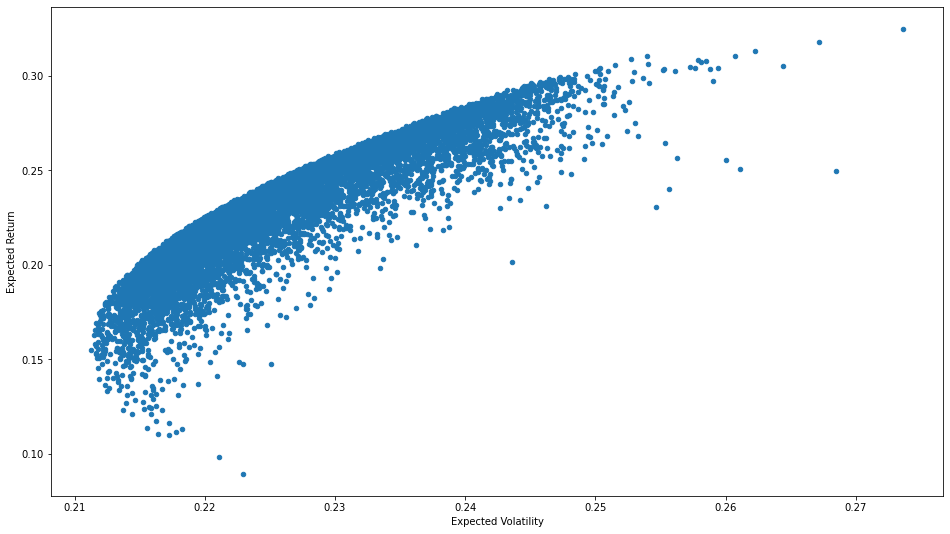

In [39]:
# plotting returns vs volatility to generate a graph of the efficiency frontier
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(16,9))
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')